In [1]:
#import packages
import pandas as pd
import numpy as np
import os

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
INPUT_PATH = os.path.join(os.getcwd())
OUTPUT_PATH = os.path.join(os.getcwd())
df_ge = pd.read_csv(os.path.join(INPUT_PATH, "data_precios.csv"), engine='python')
appl=df_ge[df_ge['SYMBOL']=='AAPL']

#print the head
appl.head()

,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,EXDIVIDEND,SPLITRATIO,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,SYMBOL
386562,1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.422706,0.424470,0.422706,0.422706,117258400.0,AAPL
386563,1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0,AAPL
386564,1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0,AAPL
386565,1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0,AAPL
386566,1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0,AAPL


/home/benayas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/benayas/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


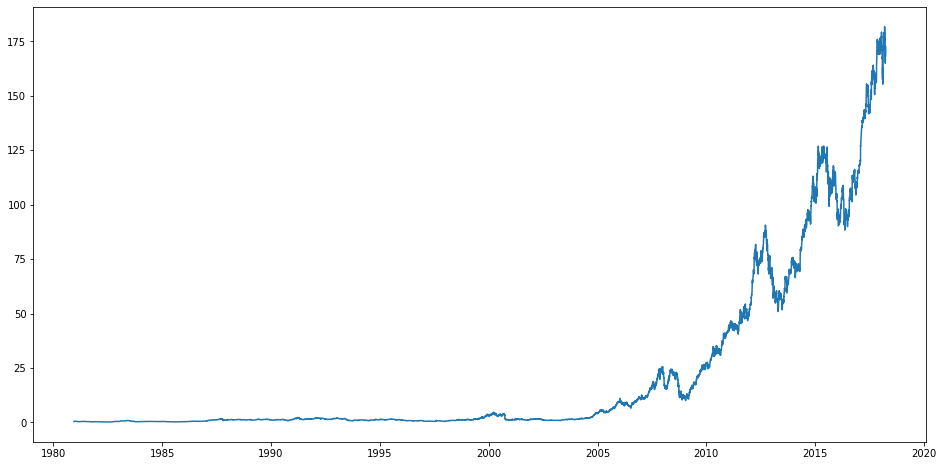

In [2]:
#setting index as date
appl['DATE'] = pd.to_datetime(appl.DATE,format='%Y-%m-%d')
appl.index = appl['DATE']

#plot
plt.figure(figsize=(16,8))
plt.plot(appl['ADJ_CLOSE'], label='Close Price history')

In [3]:
appl.shape

(9400, 14)

In [4]:
look_back = 100
forward_days = 30
num_periods = 20

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#Data Normalization
array = appl['ADJ_CLOSE'].values.reshape(appl.shape[0],1)
scl = MinMaxScaler()
array = scl.fit_transform(array)

#split in Train and Test
#division = len(array) - num_periods*forward_days
# JAVI REVISA ESTO
#array_test = array[division-look_back:]
#array_train = array[:division]

test_nuevo = dataset[dataset['DATE']>='2016-01-01']
train_nuevo = dataset[dataset['DATE']<'2016-01-01']

#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

#Training the LSTM
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 5

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=1)

'''
#creating dataframe
data = appl.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(appl)),columns=['DATE', 'ADJ_CLOSE'])
for i in range(0,len(data)):
    new_data['DATE'][i] = data['DATE'][i]
    new_data['ADJ_CLOSE'][i] = data['ADJ_CLOSE'][i]

#setting index
new_data.index = new_data.DATE
new_data.drop('DATE', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:8883,:]
valid = dataset[8883:,:]

test_nuevo = dataset[dataset['DATE']>='2016-01-01']
train_nuevo = dataset[dataset['DATE']<'2016-01-01']


#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
'''

Using TensorFlow backend.
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/py

NameError: name 'dataset' is not defined

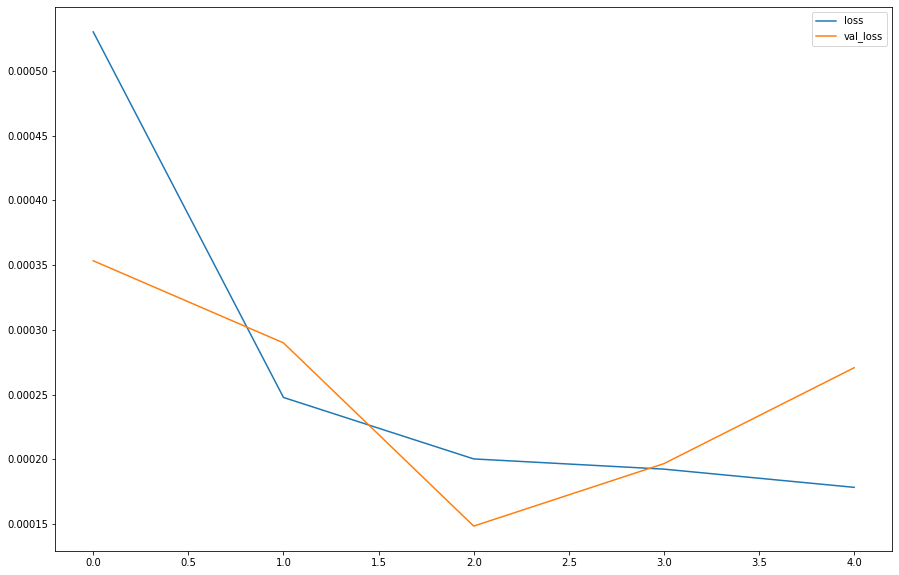

In [9]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

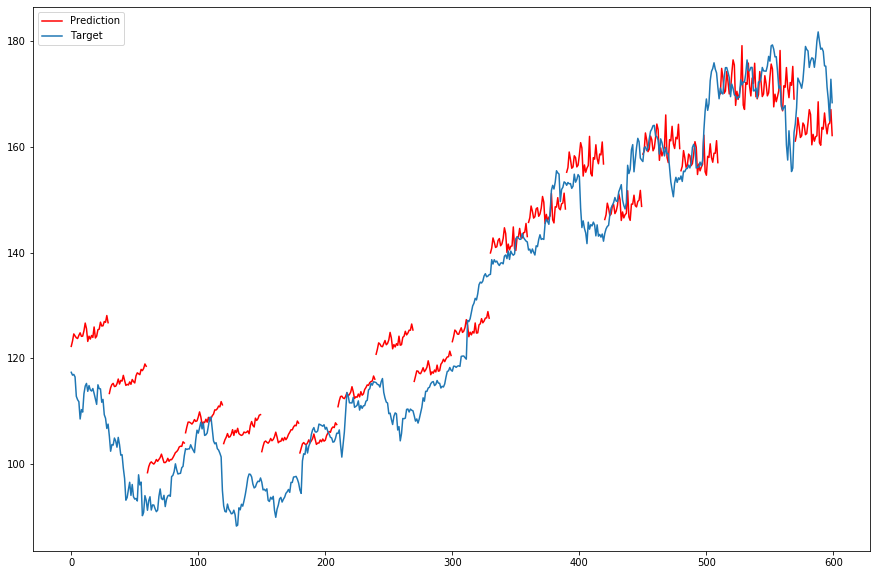

In [10]:
Xt = model.predict(X_test)
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [11]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

y = np.concatenate((ytrain, ytest), axis=0)

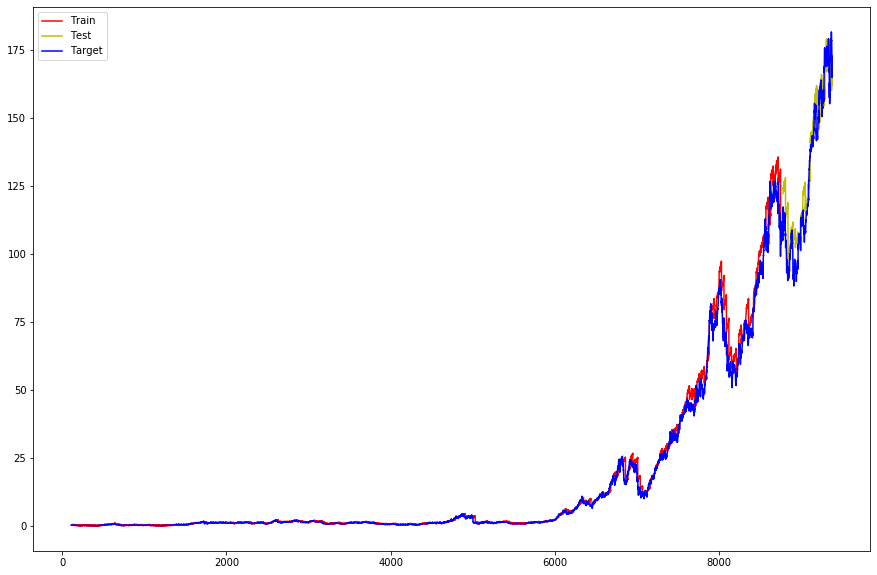

In [12]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

In [ ]:
#rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
#rms

In [ ]:
'''
#for plotting
train = new_data[:8883]
valid = new_data[8883:]
valid['Predictions'] = closing_price
plt.plot(train['ADJ_CLOSE'])
plt.plot(valid[['ADJ_CLOSE','Predictions']])
'''

In [13]:
appl['PRED']=valid['Predictions']

NameError: name 'valid' is not defined

In [ ]:
appl.tail(500)